# Imports

In [1]:
import numpy as np
import scipy.io
from scipy.stats import zscore
import os, sys
sys.path.insert(0,'..')
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from rnn.model import RNN
from rnn.task import trial_generator
from analysis.tf_utils import *
from analysis.analysis_utils import *

from pycircstat.tests import watson_williams as watson_williams_test, rayleigh
from itertools import permutations

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Initialise model and task
Here we choose and load a trained model

In [2]:
fname = "y7sfja1hSpecRad1.5DaleTrueTC20_100rand0sparse1osc2.04cost0.1"
fname = "a2r9nqtkSpecRad1.5DaleTrueTC20_100rand0sparse1osc2.04cost0.1"
fname = "a2r9nqtkSpecRad1.5DaleTrueTC20_100rand0sparse1osc2.75cost0.1"
#fname = "SpecRad1.5DaleTrue2.75cost0.1"
#fname ="ov6lf3z8SpecRad1.5DaleTrueTC20_100rand0sparse1osc1.5cost0.1"
#fname = "SpecRad1.0DaleFalse2.04cost0"
#fname = "N_items_4_N_200_Delay_260_Acc_0.8828125_tr101_2023_04_21_154006.mat"
#fname = "N_items_4_N_200_Delay_260_Acc_0.8046875_tr501_2023_04_21_145018.mat" #retrained
#fname = "N_items_4_N_200_Delay_260_Acc_0.875_tr1_2023_04_21_164052.mat"
#fname ="N_items_4_N_200_Delay_260_Acc_0.953125_tr10801_2023_04_21_182334.mat"
#fname = "N_items_4_N_200_Delay_260_Acc_0.953125_tr6801_2023_04_23_080630.mat"
#fname = "az8vlt9oSpecRad1.5DaleTrue3.74cost0.1" #accuracy = 0.5
#fname="fb4ni25cSpecRad1.5DaleTrue3.74cost0.1" #accuracy = 0.5
fname = "fb4ni25cSpecRad1.5DaleTrue2.75cost0.1" #acc = 0.5
fname = "az8vlt9oSpecRad1.5DaleTrue2.75cost0.1" #acc = 0.9

base_dir = ".."
#fname = "SpecRad1.5DaleTrue1.5cost0.5"
#task_dir = "sweep_retrain2"
task_dir = 'sweep_main'
task_dir = 'Rdelay_Sweep'
#task_dir="new"
#fname = "y7sfja1hSpecRad1.5DaleTrueTC20_100rand0sparse1osc3.73cost0.1"
model_dir = os.path.join(base_dir, "models", task_dir, fname)
net = RNN()
var = scipy.io.loadmat(model_dir)
net.load_model(model_dir)

Num GPUs Available:  0


In [3]:
len(var['val_ind'][0])/(8*7*6*5)

0.09821428571428571

## Experiment settings

Settings for running analysis and generating figures

In [4]:
ref_phase = "sine"  # Reference phase for 'spike-phase' histogram, either sine or LFP
onlyGaba = False  # Only use inhibitory neurons for calculating LFP
substr_mean_LFP = False #substract stim triggered mean from LFP
sw_tanh2log = False # substitute logistic for tanh to get pos firing rates (adjust W and B accordingly)

cutoff_p = 10e-3  # Max Wilc p allowed for stimulus triggered neurons (<1)
cutoff_d = 0  # Min Wilc d allowed stimulus selective neurons (>=0)
vex_cuttoff = 0  # Exclude neurons without strong stimulus - phase effect (>=0)

normalize_fr_extract = True  # Normalize extracted firing rates for wilc p
n_trials = 224  # Number trials used in analysis
randomize_onset = 0 # Randomise onset by at most this much
freqs_l = np.logspace(*np.log10([1, 20]), num=50) # Frequencies for scalogram
freqs_l = np.logspace(*np.log10([.5, 10]), num=50) # Frequencies for scalogram

stim_offs= 20

In [5]:
model_par, settings = reinstate_params(var)

## Instantiate variables

We instantiate some variables for convenience

In [6]:
# model parameters
out_channels = net.out_channels
n_channels = net.n_channels
n_items = int(var["n_items"][0][0])
N = var["N"][0][0]

# instantiate useful dictionaries
model_par, settings = reinstate_params(var)
settings['stim_offs']=stim_offs
settings['probe_offs']=stim_offs
settings['random_delay']=0

# set delay
delay=250 + settings['random_delay']//2

settings["delay"] = delay
settings['random_delay_per_tr']=True
# set stimulus onset
settings["stim_ons"] = 400
if randomize_onset:
    settings["rand_ons"] = int(1000/(var['lossF'][0][0]*settings['deltaT']))
else:
    settings["rand_ons"]=0
if settings["rand_ons"]>settings["stim_ons"]:
    print("WARNING, can't use this random onset, defaulting to 50 steps")
    settings["rand_ons"]=50

# batch size
settings["batch_size"] = n_trials

# delay
delay_start = (
    settings["stim_ons"]
    + n_items * settings["stim_dur"]
    + (n_items - 1) * settings["stim_offs"]
)
delay_end = delay_start + settings["delay"]

# time steps
dt_sec = int(1000 / settings["deltaT"])
timestep = settings["deltaT"] / 1000

# colors for plotting
pltcolors, pltcolors_alt = steffiscolours()

# substitute logistic for tanh
if sw_tanh2log == True:
    tanh2log(net)
    settings["x2x"] = 2

## Instantiate Trial Generator

In [7]:
# instantiate a trial generator

val_perc = 0
trial_gen = trial_generator(
    n_items,
    n_channels,
    out_channels,
    val_perc,
)

trial_gen.train_ind = var["train_ind"][0]

## Generate trials

In [8]:
# draw trials with balanced proportion of each stimuli

stims = draw_balanced_trials()
stim_ind = []
for i in range(len(stims[0])):
    ind = np.argmax(np.all(np.equal(trial_gen.all_trials_arr,stims[:,i]),axis = 1))
    stim_ind.append(ind)
trial_ind_match = stim_ind
trial_ind_non_match = stim_ind

stim, label, delays, stim_roll, isi_stim, isi_probe = trial_gen.generate_input(
    settings,
    settings["delay"],
    val=False,
    stim_ind_match=trial_ind_match,
    stim_ind_non_match=trial_ind_non_match,
)


# instantiate some more variables
stim = stim.astype(np.float64)
T = np.shape(stim)[-1]
z, mask = trial_gen.generate_target(settings, label, T, delays, stim_roll, isi_probe)
settings["T"] = T
time = np.arange(T) * settings["deltaT"] / 1000
plt_time = (
    np.arange(-settings["stim_ons"] + settings["rand_ons"], T - settings["stim_ons"])
    * settings["deltaT"]
    / 1000
)

x1, r1, o1 = net.predict(settings, stim[:, :, :])
accuracy(settings, o1, label, delays, isi_probe, stim_roll)
if sw_tanh2log == False and net.activation[0]=='tanh':
    r1+=1
    r1/=2

balanced trials converged
192
accuracy = 0.8571428571428571


In [9]:
plt_time = (
    np.arange(-settings["stim_ons"] + settings["rand_ons"], T - settings["stim_ons"])
    * settings["deltaT"]
    / 1000
)
plt_time.shape

(970,)

In [10]:
settings['rand_ons']

0

In [11]:
x1.shape

(970, 200, 224)

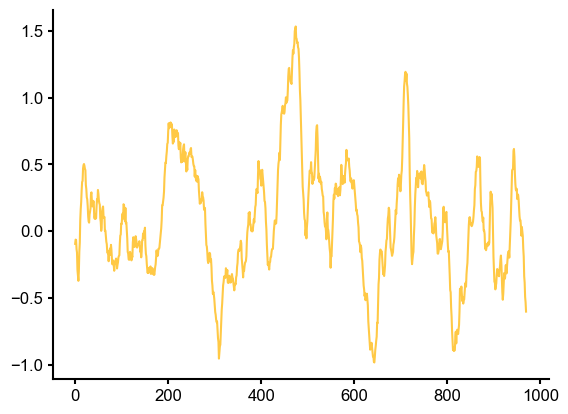

In [12]:
plt.plot(x1[:,np.random.randint(200),0]);

# Generate plots

## Figure 5d: LFPs

In [13]:
# extract local field potential
substr_mean_LFP = True
trial = np.random.choice(np.arange(n_trials))
LFP = get_LFP(var, r1, stim, onlyGaba=onlyGaba, alpha = 1)
LFP = zscore(LFP, axis=0)

if substr_mean_LFP:
    substr = np.mean(LFP, axis=1)
else:
    substr = 0

amps = []
amps_u = []

for tr in range(n_trials):
    _, amp = scalogram(
        LFP[:, tr] - substr,
        7,
        time,
        settings["deltaT"] / 1000,
        freqs_l,
    )
    amps.append(amp)

amp = np.mean(np.array(amps),axis=0)

main_freq = freqs_l[np.argmax(np.mean(amp[:, delay_start:delay_end], axis=1))]
main_power = np.max(np.mean(amp[:, delay_start:delay_end], axis=1))
baseline_freq = freqs_l[np.argmax(np.mean(amp[:, :settings["stim_ons"]], axis=1))]
baseline_power = np.max(np.mean(amp[:, :settings["stim_ons"]], axis=1))

print("delay freq = " + str(main_freq) + " with power " + str(main_power) +
      "\nbaseline freq = " + str(baseline_freq) + " with power " + str(baseline_power))
f = main_freq

delay freq = 0.5 with power 0.6125165276423413
baseline freq = 0.5 with power 0.5944252907918203


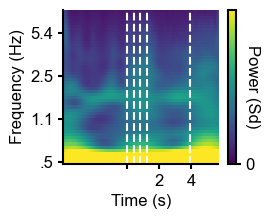

In [14]:
# Plot a spectrogram

plt_start =0
with mpl.rc_context(fname="matplotlibrc"):

    fig = plt.figure(figsize=(2.5, 2))  # , dpi = 150)
    plt.tight_layout()
    
    plt.imshow(amp[:, plt_start:], aspect="auto", cmap ='viridis', vmin = -0, vmax=.3,origin='lower')
    plt.yticks(
        np.arange(0, len(freqs_l))[::14],
        labels=["{:.1f}".format(f).strip("0") for f in freqs_l[::13]],
    )
    xt = np.arange(0, len(time[plt_start:]))[settings["stim_ons"] - plt_start :: 200]
    plt.xticks(xt, labels=["{:.0f}".format(f).strip("0") for f in np.arange(0, 2 * len(xt), 2)])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    cbar = plt.colorbar(ticks=[0,1])
    cbar.set_label("Power (Sd)", rotation=270)
    for i in range(4):
        plt.axvline(
            x=(
                settings["stim_ons"]
                - plt_start
                + i * (settings["stim_offs"] + settings["stim_dur"])
            ),
            color="white",
            linestyle="--",
            alpha=1,
            zorder=2,
        )

    plt.axvline(
        x=(delay_end - plt_start), color="white", linestyle="--", alpha=1, zorder=1
    )
    plt.savefig("../figures/LFP_fr"+str(f)+".svg")
    

## Select stimulus selective units

In [15]:
baseline_len = int(1000/(baseline_freq*settings['deltaT']))
baseline_start = max((settings["stim_ons"]-settings['rand_ons'] - baseline_len) // 2, 0)
stim_len = min(settings["stim_dur"] + settings["stim_offs"], baseline_len)

# extract stimulus triggered activity
data, labels = extract_stim_trig_act(
    r1,
    stim[:n_channels],
    stim_roll,
    settings,
    baseline_start=baseline_start,
    baseline_len=baseline_len,
    stim_len=stim_len,
    normalize=normalize_fr_extract,
)

wilc_pvals = get_wilc_pvals(data, onesided=False)
d_primes, responsive, prefered_stim = get_dprime(data, wilc_pvals, cutoff=cutoff_p)
ranked_neurons = np.argsort(d_primes)

print(
    "percentage of cells d prime > cutoff: "
    + str(np.sum(d_primes > cutoff_d) / N * 100)
)

# calculate upper and lower 50th percentile stim. selective cells
median_d = np.median(d_primes[responsive.astype(bool)])
cutoff_d = np.median(d_primes[responsive.astype(bool)])
up50th = np.arange(200)[np.logical_and(d_primes>median_d, responsive)]
low50th = np.arange(200)[np.logical_and(d_primes<median_d, responsive)]

percentage of stim responsive cells: 98.00 %
percentage of cells d prime > 0: 50.50 %
percentage of cells d prime > cutoff: 50.5


## Figure 5b: input / output

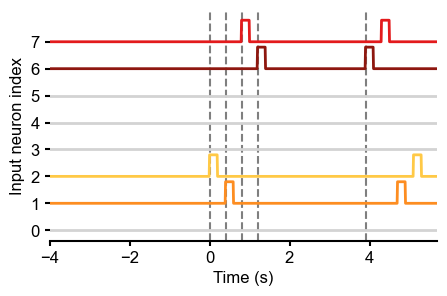

In [16]:
# plot an example trial


trial = np.random.choice(np.arange(n_trials))
plotstim = np.copy(stim[:, trial])

ci = 0
colors0 = ["lightgray" for _ in range(8)]
colors1 = ["lightgray" for _ in range(8)]
t1 = settings["stim_ons"] - settings["rand_ons"]

for i in range(4):
    labels = np.argmax(
        np.sum(stim[:n_channels, trial, t1 : t1 + settings["stim_dur"]], axis=1), axis=0
    )
    colors0[labels] = pltcolors[i]
    colors1[labels] = pltcolors[i]
    t1 += settings["stim_dur"] + settings["stim_offs"]

for i in np.arange(1, n_channels):
    plotstim[i:] += 1.25


with mpl.rc_context(fname="matplotlibrc"):

    fig = plt.figure(figsize=(5, 3))
    gs = fig.add_gridspec(1, 1)  
    axs = fig.add_subplot(gs[0])
    for i in np.arange(n_channels):
        axs.plot(plt_time, plotstim[i].T, color=colors0[i], linewidth=2)
    for i in range(4):
        axs.axvline(
            x=(i * (settings["stim_offs"] + settings["stim_dur"])) / dt_sec,
            color="black",
            linestyle="--",
            alpha=0.5,
            zorder=-1,
        )

    axs.axvline(
        x=(delay_end - settings["stim_ons"]) / dt_sec,
        color="black",
        linestyle="--",
        alpha=0.5,
        zorder=-1,
    )

    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_xlim(plt_time[0], plt_time[-1])
    axs.set_xlabel("Time (s)")
    axs.spines["left"].set_visible(False)
    axs.set_yticks(np.arange(0, 8 * 1.25, 1.25))
    axs.set_yticklabels(np.arange(8))
    axs.set_ylabel("Input neuron index")
    plt.savefig("../figures/Panel1A")
    

In [17]:
z.shape

(970, 1, 224)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


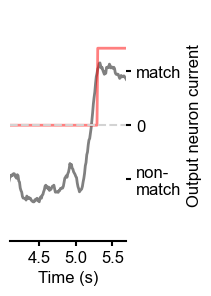

In [18]:
# plot example output
trial = np.random.choice(np.arange(n_trials))

training_params = settings
eval_delays = delay
cutoff_T = 0
probe_time = (
    training_params["stim_ons"]
    + stim_roll
    + training_params["n_items"]
    * (training_params["stim_dur"] + training_params["probe_dur"])
    + eval_delays
    + 1
    + training_params["response_ons"]
    + (training_params["n_items"] - 1) * (training_params["stim_offs"])
    + np.sum(isi_probe, axis=1)
    - cutoff_T
)

with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, 1, figsize=(1.5, 3))
    ploto = np.copy(o1[:, :, trial])
    colors = ["grey", "C2", "C3"]
    if net.out_channels == 3:
        for i in np.arange(net.out_channels):
            ploto[:, i] = np.roll(ploto[:, i], -stim_roll[trial])

            axs.plot(
                plt_time,
                ploto[settings["rand_ons"] :, i].T,
                color=colors[i],
                linewidth=2,
            )
            ploto[:, i + 1 :] += 1.25
        axs.set_ylim(-0.1, 3 * 1.25)
        axs.set_yticks(np.arange(0 + 0.6125, 3 * 1.25 + 0.6125, 1.25))
        axs.set_yticklabels(["fixate", "match", "non-\nmatch"])  # np.arange(3))
        axs.set_ylabel("Output neuron class")

    else:
        ploto[:, 0] = np.roll(ploto[:, 0], -stim_roll[trial])
        axs.plot(
            plt_time, ploto[settings["rand_ons"] :, 0].T, color=colors[0], linewidth=2
        )
        axs.plot(
            plt_time, z[settings["rand_ons"]:, 0, trial].T, 'red', linewidth=2,alpha=0.5
        )
        axs.axhline(0, color="lightgrey", ls="--")
        axs.set_ylim(-1.5, 1.5)
        axs.set_yticks([-0.7, 0, 0.7])
        axs.set_yticklabels(["non-\nmatch", "0", "match"])  # np.arange(3))

        axs.set_ylabel("Output neuron current")
    axs.axvline(
        x=(delay_end - settings["stim_ons"]) / dt_sec,
        color="black",
        linestyle="--",
        alpha=0.5,
        zorder=-1,
    )

    axs.spines["top"].set_visible(False)

    axs.set_xlim(plt_time[-settings["response_dur"]*4], plt_time[-1])
    axs.set_xlabel("Time (s)")
    axs.spines["left"].set_visible(False)
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()

    plt.savefig("../figures/Panel1C")  # transparent=False)
    plt.savefig("../figures/Example_output.eps")

In [19]:
#inp = np.zeros((8,1,780))
#inp[0,0,:]=1
#x1, r1, o1 = net.predict(settings, inp)

In [20]:
#plt.plot(x1[:,:20,0]);

In [21]:
#import copy

In [22]:
#stim_ind=2
#d_th=0

In [23]:
#net_ablatet = copy.deepcopy(net)

In [24]:
#net_ablatet.initializer['w_rec'][prefered_stim!=stim_ind,:]=0
#net_ablatet.initializer['w_rec'][:,prefered_stim!=stim_ind]=0
#net_ablatet.initializer['w_rec'][d_primes<d_th,:]=0
#net_ablatet.initializer['w_rec'][:,d_primes<d_th]=0
#net_ablatet.initializer['w_rec']*=2
#plt.imshow(net_ablatet.initializer['w_rec'])

In [25]:
#x1, r1, o1 = net_ablatet.predict(settings, np.zeros_like(stim[:, :, :]))
#plt.plot(x1[:,prefered_stim==stim_ind,0],color ='black',alpha=0.5);

## Figure 5c: mean currents

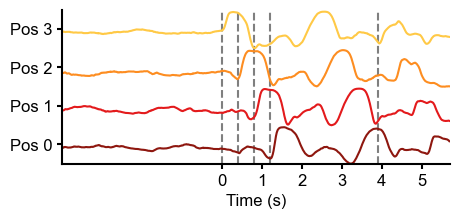

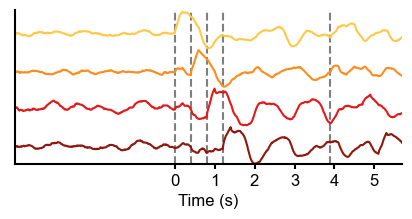

In [26]:
# Plot mean currents with Poisson spikes

scale =60 # for line plots
spikesize = 0.5 # spike size in plots
spike_scale = 7 # for scaling rate parameter in poisson

plt_tr_int = 1 # we take one out of every plt_tr_int trials for spike raster plots to avoid cluttering them

plt_neurons = ranked_neurons[-2:]

with mpl.rc_context(fname="matplotlibrc"):

    
    for neui, neuron in enumerate(plt_neurons):
        # Create Figure
        fig = plt.figure(figsize=(5,2))
        gs = gridspec.GridSpec(1, 1)    

        # Extract traces of pref stim
        traces_all = [[] for i in np.arange(4)]
        pref_stim = prefered_stim[neuron]
        traces_pref, _ = extract_traces(r1, stim, neuron, pref_stim, settings)
        for it in range(settings['n_items']):
            for tr in range(traces_pref[it].shape[1]):
                pref = traces_pref[it][:,tr]
                traces_all[it].append(pref)


        # Extract spiking information
        spike_times = []
        counter = 0
        hbars = []
        r_im = np.concatenate([traces_all[i][::plt_tr_int] for i in range(4)], axis = 0)
        all_spikes, r = draw_spikes(r_im.T/spike_scale, 0, r_im.shape[1])
        spike_times = [np.arange(0,r_im.shape[1])[spikes] for spikes in all_spikes]
        spike_colors = []
        for i in range(settings['n_items']):
            for tr in range(np.array(traces_all[i][::plt_tr_int]).shape[0]):
                spike_colors.append('black')

        ax0 = plt.subplot(gs[0])
        # Spike raster plot
        #ax0.eventplot(spike_times, color = spike_colors, linelengths=spikesize, linewidths=spikesize);
        
        for i in np.flip(np.arange(4)):
            meantr = np.mean(traces_all[i][::plt_tr_int], axis = 0)
            meantr -= np.min(meantr)
            meantr/=np.max(meantr) #to [0,1]
            meantr*=len(traces_all[i][::plt_tr_int])*0.95 #scale to fit spike size
            ax0.plot(np.arange(r_im.shape[1]), counter + meantr, color = pltcolors[i])

            counter +=np.array(traces_all[i][::plt_tr_int]).shape[0]
            hbars.append(counter-np.array(traces_all[i][::plt_tr_int]).shape[0]/2)
            ax0.axvline(x=settings['stim_ons']-settings['rand_ons']+(i*(settings['stim_offs']+settings['stim_dur'])), \
                        color = 'black', linestyle = '--', alpha = 0.5, zorder=-1)

        ax0.axvline(x=(delay_end - settings['rand_ons']), color = 'black', linestyle = '--', alpha = 0.5, zorder=-1)
        ax0.set_ylim(0,counter)
        ax0.set_xlim(0,r_im.shape[1])
        all_ind = np.arange(r_im.shape[1])
        ind_start = settings['stim_ons']-settings['rand_ons']             
        ticks =all_ind[ind_start::dt_sec]
        ax0.set_xticks(ticks)
        ax0.set_xticklabels(["{:0.0f}".format(lab) for lab in plt_time[ticks]])
        ax0.set_xlabel("Time (s)")


        hbars_pos = [bar for bar in hbars]
        ax0.set_yticks([])
        if neui==0:
            ax0.set_yticks(hbars_pos)
            ax0.set_yticklabels(['Pos ' +str(i) for i in range(4)])
        ax0.spines['right'].set_visible(False)
        ax0.spines['top'].set_visible(False)
        plt.savefig("../figures/single_unit"+ str(neui)+"fr"+str(f)+".svg")

## Calculate variance explained

In [27]:
delay_buffer1 = 25 
delay_buffer2 = 25 
nbins = 20
freqs = [1,main_freq]#np.arange(0.5,4.6,0.4)#[0.5,1,1.5main_freq]

In [28]:
# Calculate variance explained
perms = list(set(permutations([1, 2, 3])))
perms= np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])

n_perm = 1

t1 = delay_start + delay_buffer1 - settings["rand_ons"]
t2 = delay_end - delay_buffer2 - settings["rand_ons"]
delay_time = time[t1:t2]
neurons_plot = ranked_neurons[-int(np.sum(d_primes > cutoff_d)):]
numplot = len(neurons_plot)
for f in freqs:
    if dt_sec / f < nbins:
        print("Warning: too much bins for f = " + str(f))

bin_lims = np.linspace(-np.pi, np.pi, nbins + 1)
bin_centers = bin_lims[:-1] + np.pi / nbins
width = 2 * np.pi / (nbins)

vex = np.zeros((len(freqs), N))
shvex = np.zeros((len(freqs), N))
shuffle_ind = np.random.choice(np.arange(n_items), (n_trials, n_perm))



n_match=np.zeros((len(freqs),6))
for neui, neuron in enumerate(neurons_plot):

    if neui % 10 == 0:
        print("{:.2f}% done".format(100 * neui / len(neurons_plot)))

    pref_stim = prefered_stim[neuron]
    pref_r, _, LFPs = extract_traces(
        r1, stim, neuron, pref_stim, settings, True, var, onlyGaba
    )
    for fi, f in enumerate(freqs):

        watsdat = []
        watsw = []
        watsw_shuffle = [[] for _ in range(n_perm)]
        spikephasehist_shuffle = np.zeros((4, nbins, n_perm))
        counter = 0
        cwt = complex_wavelet(timestep, f, 7)
        shuffle_ind[:,1:] = np.random.choice(np.arange(n_items), (n_trials, n_perm-1))
        avgs=np.zeros(4)
        
        for stim_pos in range(settings["n_items"]):
            spikephasehist = np.zeros(nbins)
            for tr in range(np.array(LFPs[stim_pos]).shape[1]):
                if ref_phase == "sine":
                    LFP_phase = wrap(time * 2 * np.pi * f)
                elif ref_phase == "LFP":
                    LFP_phase, _ = inst_phase(
                        LFPs[stim_pos][:, tr], cwt, time, f, ref_phase=False
                    )
                else:
                    print("WARNING: reference phase not recognised!")

                bin_ind = np.digitize(LFP_phase[t1:t2], bin_lims) - 1
                firing_trace = pref_r[stim_pos][t1:t2, tr]
                for b in range(nbins):
                    summed_spikes = np.sum(firing_trace[bin_ind == b])
                    occ = np.count_nonzero(bin_ind == b)
                    if occ > 0:
                        spikephasehist[b] += summed_spikes / occ
                        for permi in range(n_perm):
                            spikephasehist_shuffle[shuffle_ind[counter,permi], b, permi] += (
                                summed_spikes / occ
                            )
                counter += 1
            avg, avglen = circ_mean(bin_centers, spikephasehist)
            watsw.append(np.array(spikephasehist))
            watsdat.append(bin_centers)
            avgs[stim_pos]=avg
        #print(avgs)
        # Calculate amount matching certain stim order
        avgs -= avgs[0]
        avgs[avgs < 0] += np.pi * 2
        for permi, perm in enumerate(perms):
            if (np.argsort(avgs)[1:] == np.array(perm)).all():
                n_match[fi, permi] += 1
                #print("neuron no: " + str(neuron) + "phase order " + str(permi))


        for stim_pos in range(settings["n_items"]):
            for permi in range(n_perm):
                watsw_shuffle[permi].append(np.array(spikephasehist_shuffle[stim_pos, :, permi]))

        anovatable = watson_williams_test(
            bin_centers, bin_centers, bin_centers, bin_centers, w=watsw_shuffle[0]
        )[1]
        shvex[fi, neuron] = anovatable["SS"][0] / anovatable["SS"][2]

        anovatable = watson_williams_test(
            watsdat[0], watsdat[1], watsdat[2], watsdat[3], w=watsw
        )[1]
        vex[fi, neuron] = anovatable["SS"][0] / anovatable["SS"][2]

vex_fr_ind = np.argmax(np.sum(vex, axis=1))
vex_fr = freqs[vex_fr_ind]

0.00% done


/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(


10.20% done
20.41% done
30.61% done
40.82% done
51.02% done
61.22% done
71.43% done
81.63% done
91.84% done


In [29]:
print(n_match)
print(perms)
print(vex_fr)

[[62. 11.  2.  7. 12.  4.]
 [ 4.  4.  1. 10. 58. 21.]]
[[3 1 2]
 [1 3 2]
 [3 2 1]
 [2 3 1]
 [1 2 3]
 [2 1 3]]
0.5


## Figure 5e: 'spike' phase histograms

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


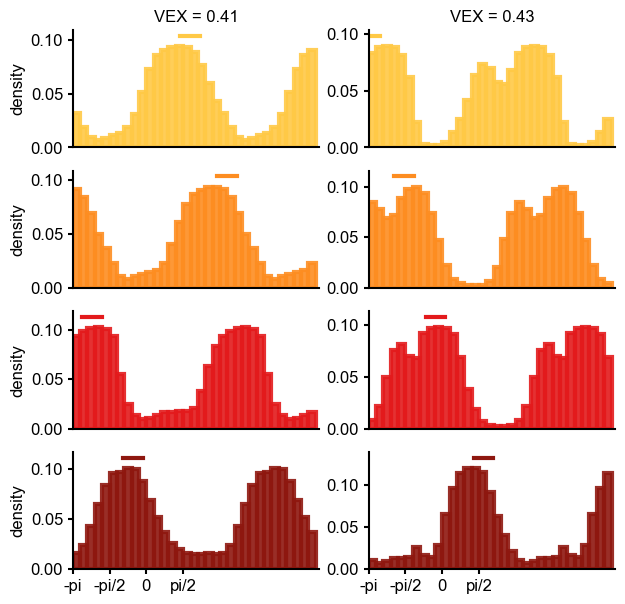

In [30]:
# Plot 'spike' phase histograms


nbins = 20
vex_ind = np.argsort(vex[vex_fr_ind])[-np.sum(d_primes > cutoff_d) :]
ind = [-2, -1]
plt_neurons = vex_ind[ind] 


f = vex_fr  # main_freq
cwt = complex_wavelet(timestep, f, 7)


delay_time = time[t1:t2]
bin_lims = np.linspace(-np.pi, np.pi, nbins + 1)
bin_centers = bin_lims[:-1] + np.pi / nbins
width = 2 * np.pi / (nbins)
circ_ticks = np.arange(-np.pi, np.pi, np.pi / 2)
circ_ticklabs = ["-pi", "-pi/2", "0", "pi/2"]


with mpl.rc_context(fname="matplotlibrc"):

    fig = plt.figure(figsize=(7, 7))
    gs = gridspec.GridSpec(4, 2)
    for neui, neuron in enumerate(plt_neurons):

        # Extract traces of pref stim
        traces_all = [[] for i in np.arange(4)]
        pref_stim = prefered_stim[neuron]
        traces_pref, _, LFPs = extract_traces(
            r1, stim, neuron, pref_stim, settings, True, var, onlyGaba
        )
        for it in range(settings["n_items"]):
            for tr in range(traces_pref[it].shape[1]):
                pref = traces_pref[it][:, tr]
                traces_all[it].append(pref)

        # Extract Histogram information and plot Histogram

        maxh = np.zeros(4)
        avgs = np.zeros(4)
        for stim_pos in np.arange(settings["n_items"]):
            ax1 = plt.subplot(gs[stim_pos, neui])

            spikephasehist = np.zeros(nbins)
            for tr in range(np.array(traces_pref[stim_pos]).shape[1]):
                if ref_phase == "sine":
                    LFP_phase = wrap(time * 2 * np.pi * f)
                elif ref_phase == "LFP":
                    LFP_phase, _ = inst_phase(
                        LFPs[stim_pos][:, tr], cwt, time, f, ref_phase=False
                    )
                else:
                    print("WARNING: reference phase not recognised!")
                bin_ind = np.digitize(LFP_phase[t1:t2], bin_lims) - 1
                firing_trace = traces_pref[stim_pos][t1:t2, tr]
                for b in range(nbins):
                    summed_spikes = np.sum(firing_trace[bin_ind == b])
                    occ = np.count_nonzero(bin_ind == b)
                    if occ > 0:
                        spikephasehist[b] += summed_spikes / occ
            spikephasehist /= np.sum(spikephasehist)
            avg, avglen = circ_mean(bin_centers, spikephasehist)
            avg += np.pi
            avg /= np.pi * 2
            avg /= 1.5
            maxh[stim_pos] = max(spikephasehist)
            avgs[stim_pos] = avg

            ax1.bar(
                np.concatenate([bin_centers, (bin_centers + np.pi * 2)[: -nbins // 3]]),
                np.concatenate([spikephasehist, spikephasehist[: -nbins // 3]]),
                width=width,
                color=pltcolors[stim_pos],
                ec=pltcolors[stim_pos],
                linewidth=3,
                alpha=0.9,
                label="Pos:" + str(stim_pos + 1),
            ) 
            
            ax1.axhline(
                (maxh[stim_pos]) * 1.1,
                avgs[stim_pos] - 0.04,
                avgs[stim_pos] + 0.04,
                color=pltcolors[stim_pos],
                linewidth=3,
            )  
            ax1.set_xticks([])
            ax1.set_xlim(circ_ticks[0], (bin_centers + np.pi * 2)[-nbins // 3])
            ax1.set_xticklabels([])
            if stim_pos == 0:
                ax1.set_title("VEX = {:.2f}".format(vex[vex_fr_ind, neuron]))
            if neui == 0:
                ax1.set_ylabel("density") 

        
            ax1.spines["right"].set_visible(False)
            ax1.spines["top"].set_visible(False)
        ax1.set_xticks(circ_ticks)
        ax1.set_xticklabels(circ_ticklabs)
    plt.savefig("../figures/spike_phase_hist_fr"+str(f)+".eps", transparent=False)

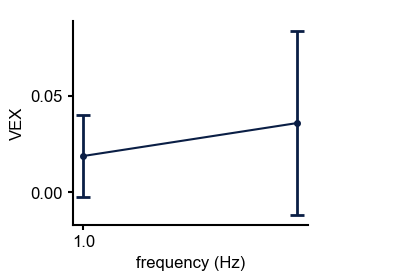

In [31]:
# Plot Kappa per frequency, upper versus lower percentile d'

shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]



with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
    fig.tight_layout()
    axs.errorbar(
        np.arange(len(freqs)),
        np.mean(vex[-np.sum(d_primes > cutoff_d) :], axis=1),
        np.std(vex[-np.sum(d_primes > cutoff_d) :], axis=1)/np.sqrt(len(vex[-np.sum(d_primes > cutoff_d) :])),
        marker="o",
        color=pltcolors_alt[3],
        zorder=i+5,
        capsize=5,
        elinewidth=2,
        markeredgewidth=2,
    )  

    axs.set_yticks(np.arange(0, 0.1, 0.05))

    axs.set_xticks(np.arange(len(freqs))[::2])
    axs.set_xticklabels(["{:.1f}".format(fr) for fr in freqs[::2]])
    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_ylabel("VEX")
    axs.set_xlabel("frequency (Hz)")

    handles, labels = axs.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    plt.legend(
        handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
    )
    #plt.savefig("../figures/SummF", facecolor="None", transparent=True)
    #plt.savefig("../figures/Kappa_per_F_and_Perc.eps")
    plt.savefig("../figures/vex.svg")

In [32]:
# Plot 'spike' phase histograms
"""

nbins = 20

plt_neurons =np.arange(200)[d_primes > cutoff_d]


f = vex_fr  # main_freq
cwt = complex_wavelet(timestep, f, 7)


delay_time = time[t1:t2]
bin_lims = np.linspace(-np.pi, np.pi, nbins + 1)
bin_centers = bin_lims[:-1] + np.pi / nbins
width = 2 * np.pi / (nbins)
circ_ticks = np.arange(-np.pi, np.pi, np.pi / 2)
circ_ticklabs = ["-pi", "-pi/2", "0", "pi/2"]
# For counting Percentage matching order
perms = list(set(permutations([1, 2, 3])))
perms= np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])

n_match = np.zeros(len(perms))



for neui, neuron in enumerate(plt_neurons):

    # Extract traces of pref stim
    traces_all = [[] for i in np.arange(4)]
    pref_stim = prefered_stim[neuron]
    traces_pref, _, LFPs = extract_traces(
        r1, stim, neuron, pref_stim, settings, True, var, onlyGaba
    )
    for it in range(settings["n_items"]):
        for tr in range(traces_pref[it].shape[1]):
            pref = traces_pref[it][:, tr]
            traces_all[it].append(pref)

    # Extract Histogram information and plot Histogram

    maxh = np.zeros(4)
    avgs = np.zeros(4)
    for stim_pos in np.arange(settings["n_items"]):

        spikephasehist = np.zeros(nbins)
        for tr in range(np.array(traces_pref[stim_pos]).shape[1]):
            if ref_phase == "sine":
                LFP_phase = wrap(time * 2 * np.pi * f)
            elif ref_phase == "LFP":
                LFP_phase, _ = inst_phase(
                    LFPs[stim_pos][:, tr], cwt, time, f, ref_phase=False
                )
            else:
                print("WARNING: reference phase not recognised!")
            bin_ind = np.digitize(LFP_phase[t1:t2], bin_lims) - 1
            firing_trace = traces_pref[stim_pos][t1:t2, tr]
            for b in range(nbins):
                summed_spikes = np.sum(firing_trace[bin_ind == b])
                occ = np.count_nonzero(bin_ind == b)
                if occ > 0:
                    spikephasehist[b] += summed_spikes / occ
        spikephasehist /= np.sum(spikephasehist)
        avg, avglen = circ_mean(bin_centers, spikephasehist)
        avg += np.pi
        avg /= np.pi * 2
        avg /= 1.5
        maxh[stim_pos] = max(spikephasehist)
        avgs[stim_pos] = avg

    # Calculate order of phases
    phase_order = np.argsort(avgs)

    # Calculate amount matching certain stim order
    avgs -= avgs[0]
    avgs[avgs < 0] += np.pi * 2
    for permi, perm in enumerate(perms):
        if (np.argsort(avgs)[1:] == np.array(perm)).all():
            n_match[permi] += 1
            #print("neuron no: " + str(neuron) + "phase order " + str(permi))



""";


In [33]:
stim.shape

(8, 224, 970)

In [34]:
f = vex_fr#var['lossF'][0][0]
#f=1.25
#f=1.5
period= int(1000/(f*settings['deltaT']))

In [35]:
f

0.5

In [36]:
all_trials = np.array(list(all_trials))
np.sum(all_trials[:,0]==4)

NameError: name 'all_trials' is not defined

In [ ]:
np.sum(all_trials==4,axis=1).astype(bool)

In [ ]:
(2*20/period)

In [ ]:
ph_inc = (2*20/period)*2*np.pi
print(ph_inc)

### Set up a regression analysis

In [ ]:
all_trials = set(permutations(np.arange(8), int(4)))
all_trials = np.array(list(all_trials))
period= int(1000/(f*settings['deltaT']))

def get_W0(f,settings,net,rec_noise=0,stim_st=20, trial_dur=400,code_st=300,alpha=0.05,stim_dur=20,n_comp=5):

    trials_inc = np.arange(len(all_trials))
    batch_size = len(trials_inc) 
    settings["batch_size"]=batch_size
    period= int(1000/(f*settings['deltaT']))
    
    #-----
    #ST1
    inp = np.zeros((8,batch_size,trial_dur))
    rstims = np.arange(0,8)
    ph_inc = (2*stim_dur/period)*2*np.pi
    #x shape (time, units, bs)

    st=stim_st
    y = np.zeros((period,8,batch_size))
    
    for i, trial_ind in enumerate(trials_inc):
        st=stim_st
        for pos_ind,st_ind in enumerate(all_trials[trial_ind]):
            inp[st_ind,i,st:st+stim_dur]=1
            y[pos_ind*8+st_ind,i]
            st+=2*stim_dur
            y[:,st_ind,i]=np.linspace(0,np.pi*2,period)-ph_inc*pos_ind

    y=np.sin(y)
    #Y[3*b_inc:]=0
    net.rec_noise=rec_noise
    x, r, o = net.predict(settings, inp)
    sig2 = r[code_st:code_st+period,:,:]
    X=sig2
    Y=y
    X=np.transpose(X,(2,0,1))
    Y=np.transpose(Y,(2,0,1))
    Y=Y.reshape(batch_size*period,8)
    X=X.reshape(batch_size*period,200)       
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    print(pca.explained_variance_ratio_)
    X_den = pca.transform(X)
    clf = Ridge(alpha=alpha,fit_intercept=False)
    clf.fit(X_den, Y)
    return inp,y, x,clf.coef_,labels,pca



In [ ]:
all_trials = set(permutations(np.arange(8), int(4)))
all_trials = np.array(list(all_trials))
period= int(1000/(f*settings['deltaT']))

def get_W0(f,settings,net,rec_noise=0,stim_st=20, trial_dur=450,code_st=300,alpha=0.05,stim_dur=20,n_comp=5):

    trials_inc = np.arange(len(all_trials))
    batch_size = len(trials_inc) 
    settings["batch_size"]=batch_size
    period= int(1000/(f*settings['deltaT']))
    
    #-----
    #ST1
    inp = np.zeros((8,batch_size,trial_dur))
    rstims = np.arange(0,8)
    ph_inc = (2*stim_dur/period)*2*np.pi
    #x shape (time, units, bs)

    st=stim_st
    y = np.zeros((8*4,batch_size))

    for i, trial_ind in enumerate(trials_inc):
        st=stim_st
        for pos_ind,st_ind in enumerate(all_trials[trial_ind]):
            inp[st_ind,i,st:st+stim_dur]=1
            y[pos_ind*8+st_ind,i]=1

            st+=2*stim_dur

    #Y[3*b_inc:]=0
    net.rec_noise=rec_noise
    x, r, o = net.predict(settings, inp)
    sig2 = r[code_st:code_st+period,:,:]
    X=sig2
    Y=y.T
    X=np.transpose(X,(2,0,1))
    #Y=np.transpose(Y,(2,0,1))
    #Y=Y.reshape(batch_size*period,8)
    X=X.reshape(batch_size,period*200)       
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    print(pca.explained_variance_ratio_)
    X_den = pca.transform(X)
    clf = Ridge(alpha=alpha,fit_intercept=False)
    print(X_den.shape)
    print(Y.shape)
    clf.fit(X_den, Y)
    return inp,y, x,clf.coef_,labels,pca



In [ ]:
f

In [ ]:
inp,y, x,proj_w,labels,pca=get_W0(f,settings,net,alpha=0,n_comp=100)


In [ ]:
plt.plot(y[:,1])

In [ ]:
y.shape

In [ ]:
period= int(1000/(f*settings['deltaT']))

n_trials = 1000
X = x[-period:,:,:n_trials]
Y = y[:,:n_trials].T

X=np.transpose(X,(2,0,1))
X=X.reshape(n_trials,200*period) 
n_comp=5
pca = PCA(n_components=n_comp)
pca.fit(X)
Xt = pca.transform(X)
w= np.linalg.inv(Xt.T@Xt)@Xt.T@Y
ws=pca.components_.T@w
#plt.plot(X@ws)
plt.imshow((Xt@w)[:20])#,color='black')

#plt.plot(Y)


In [ ]:
plt.imshow(Y[:20])

In [ ]:
Xt@w

In [ ]:
plt.imshow(np.expand_dims(Y[:,0],0), aspect='auto')
plt.colorbar()

In [ ]:
X.shape

In [ ]:
pca.components_.shape

In [ ]:
w.shape

In [ ]:
y.shape

In [ ]:
plt.imshow(X)

In [ ]:
pca.whiten

In [ ]:
n_trials = 5
X = x[:,:,:n_trials]
Y = y[:,:,:n_trials]

X=np.transpose(X,(2,0,1))
Y=np.transpose(Y,(2,0,1))
Y=Y.reshape(n_trials*period,8)
X=X.reshape(n_trials*period,200) 
n_comp=60
pca = PCA(n_components=n_comp)
pca.fit(X)
Xt = pca.transform(X)
w= np.linalg.inv(Xt.T@Xt)@Xt.T@Y
ws=pca.components_.T@w
#plt.plot(X@ws)
plt.plot(Xt@w,color='black')

plt.plot(Y)


In [ ]:
plt.imshow((Xt@w)[:period*3],aspect='auto')

In [ ]:
plt.imshow(((X-np.mean(X,axis=0))@ws)[:period*3],aspect='auto')

In [ ]:
plt.imshow(y[:,:,80].T,aspect='auto')

In [ ]:
plt.imshow(inp[:,80],aspect='auto')

In [ ]:
inp,y, x,proj_w,labels,pca=get_W0(f,settings,net,alpha=0,n_comp=100)


In [ ]:
ws=proj_w@pca.components_


In [ ]:
stim_input = np.zeros((8,1,800))
st=200
for i in range(2):
    stim_input[i,0,st:st+20]=1
    st+=200
plt.plot(stim_input[:,0].T);
settings['batch_size']=1
x, r, o = net.predict(settings, stim_input)
plt.figure()
for i in range(8):
    plt.plot((x[:,:,0]-np.mean(x[:,:,0],axis=0))@ws[i]/np.max(abs(x[:,:,0]@ws[0]))+2*i)
    plt.plot((x[:,:,0]-np.mean(x[:,:,0],axis=0))@ws[0]/np.max(abs(x[:,:,0]@ws[0]))+2*i,color='grey',zorder=-1,alpha=0.5)
plt.plot(stim_input[:,0].T,color='black',zorder=-2);


In [ ]:
all_trials = set(permutations(np.arange(8), int(4)))
all_trials = np.array(list(all_trials))
period= int(1000/(f*settings['deltaT']))

def get_W(stim_ind,f,settings,net,rec_noise=0,stim_st=20, trial_dur=400,code_st=300,alpha=0.05,stim_dur=20,n_comp=5):

    trials_inc = np.arange(len(all_trials))[np.sum(all_trials==stim_ind,axis=1).astype(bool)]
    batch_size= len(trials_inc)
    
    settings["batch_size"]=batch_size
    period= int(1000/(f*settings['deltaT']))
    #-----
    #ST1
    inp = np.zeros((8,batch_size,trial_dur))
    rstims = np.arange(0,8)
    ph_inc = (2*stim_dur/period)*2*np.pi
    y = np.tile(np.linspace(0,np.pi*2,period),(batch_size,1))
    st=stim_st
    
    labels=np.zeros(batch_size)
    for i, trial_ind in enumerate(trials_inc):
        st=stim_st
        for pos_ind in range(4):
            st_ind = all_trials[trial_ind,pos_ind]
            inp[st_ind,i,st:st+stim_dur]=1
            if st_ind==stim_ind:
                y[i]-=ph_inc*pos_ind
                labels[i]=pos_ind
            st+=2*stim_dur

    y=np.sin(y)
    #Y[3*b_inc:]=0
    net.rec_noise=rec_noise
    x, r, o = net.predict(settings, inp)
    sig2 = r[code_st:code_st+period,:,:]
    X=sig2
    X=np.transpose(X,(2,0,1))
    X=X.reshape(batch_size*period,200)
    
    
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    print(pca.explained_variance_ratio_)
    X_den = pca.transform(X)
    Y=y.reshape(batch_size*period,1) 
    clf = Ridge(alpha=alpha,fit_intercept=True)
    clf.fit(X_den, Y)
    return y, x,clf.coef_[0],labels,pca



In [ ]:
ws=[]
for i in range(8):
    y, x,proj_w,labels,pca=get_W(i,f,settings,net,alpha=0,n_comp=10)
    ws.append(pca.components_.T@proj_w)
    print((pca.components_.T@proj_w).shape)
    t2=-100
    trials_inc = np.arange(len(all_trials))[np.sum(all_trials==i,axis=1).astype(bool)]
    batch_size= len(trials_inc)
    
    for i in np.arange(batch_size)[labels==0]:
        plt.plot(pca.transform(x[t2:t2+period,:,i])@proj_w,color='red',alpha=0.2)
    for i in np.arange(batch_size)[labels==1]:
        plt.plot(pca.transform(x[t2:t2+period,:,i])@proj_w,color='blue',alpha=0.2)
    for i in np.arange(batch_size)[labels==2]:
        plt.plot(pca.transform(x[t2:t2+period,:,i])@proj_w,color='green',alpha=0.2)

In [ ]:
x.shape

In [ ]:
stim_input = np.zeros((8,1,800))
st=200
for i in range(2):
    stim_input[i,0,st:st+20]=1
    st+=200
plt.plot(stim_input[:,0].T);
settings['batch_size']=1
x, r, o = net.predict(settings, stim_input)
plt.figure()
for i in range(8):
    plt.plot(x[:,:,0]@ws[i]/np.max(abs(x[:,:,0]@ws[i]))+2*i)
    plt.plot(x[:,:,0]@ws[0]/np.max(abs(x[:,:,0]@ws[0]))+2*i,color='grey',zorder=-1,alpha=0.5)
plt.plot(stim_input[:,0].T,color='black',zorder=-2);


In [ ]:
ws = np.array(ws)
ws/=np.linalg.norm(ws,axis=1,keepdims=True)

In [ ]:
plt.imshow(ws@ws.T)
plt.colorbar()

In [ ]:
y = np.linspace(0,np.pi*2,period)
plt.plot(np.sin(y))
plt.plot(np.sin(y-0.67*np.pi*2))

In [ ]:
batch_size = len(all_trials)//2
for i in np.arange(batch_size)[labels==0]:
    plt.plot(y[i],color='red',alpha=0.2)
for i in np.arange(batch_size)[labels==1]:
    plt.plot(y[i],color='blue',alpha=0.2)
#for i in np.arange(batch_size)[labels==2]:
#    plt.plot(x[t2:t2+period,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:
t2=300
y, x,proj_w,labels,pca=get_W(0,f,settings,net,alpha=1,n_comp=5)
plt.plot(x[t2:t2+period,::10,i],color='blue',alpha=0.05);
plt.plot(y[i],color='black');
plt.plot(pca.transform(x[t2:t2+period,:,i])@proj_w,color='red',alpha=1)

X= x[t2:t2+period,:,i]
Y = y[i]
W = np.linalg.inv(X.T@X)@X.T@Y
#plt.plot(x[t2:t2+period,:,i]@W,color='purple',alpha=1);


In [ ]:
t2=300
y, x,proj_w,labels,pca=get_W(0,f,settings,net,alpha=1,n_comp=5)
plt.plot(x[t2:t2+period,::10,i],color='blue',alpha=0.05);
plt.plot(y[i],color='black');
plt.plot(x[t2:t2+period,:,i]@(pca.components_.T@proj_w),color='red',alpha=1)

X= x[t2:t2+period,:,i]
Y = y[i]
W = np.linalg.inv(X.T@X)@X.T@Y
#plt.plot(x[t2:t2+period,:,i]@W,color='purple',alpha=1);


In [ ]:
for i in range(10):
    plt.figure(figsize=(1,1))
    plt.plot(x[t2:t2+period,::10,i],color='blue',alpha=0.05);
    plt.plot(y[i],color='black');
    plt.plot(pca.transform(x[t2:t2+period,:,i])@proj_w,color='red',alpha=1)
    plt.title(labels[i])
    #plt.plot(x[t2:t2+period,:,i]@W,color='purple',alpha=1);


In [ ]:
n_features =200

X= x[t2:t2+period,:n_features,i]
Y = y[i]

pca = PCA(n_components=5)
pca.fit(X)
print(np.sum(pca.explained_variance_ratio_))
X_den = pca.transform(X)
print(X_den.shape)


W = np.linalg.inv(X_den.T@X_den)@X_den.T@Y


plt.plot(X_den@W,color='purple',alpha=1, label='prediction');
plt.plot(y[i],ls='--',color='orange',label='target');
plt.legend()

In [ ]:
u,s,v = np.linalg.svd(X.T@X)
plt.plot(s[10:])

In [ ]:
clf = Ridge(alpha=0,fit_intercept=False)
clf.fit(X, Y)
W=clf.coef_
plt.plot(X@W,color='red',alpha=1)


In [ ]:
for i in np.arange(batch_size)[labels==0]:
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='red',alpha=0.2)
for i in np.arange(batch_size)[labels==1]:
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='blue',alpha=0.2)
for i in np.arange(batch_size)[labels==2]:
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:
for i in np.arange(batch_size)[labels==2]:
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:

t2=-100
#for i in range(batch_size//4):
#    plt.plot(x[t2:t2+period,:,i]@proj_w,color='black',alpha=0.4)
for i in range(batch_size//4,batch_size//2):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='red',alpha=0.2)
for i in range(batch_size//2,batch_size-batch_size//4):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='blue',alpha=0.2)
for i in range(batch_size-batch_size//4,batch_size):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:
plt.plot(x[:,:,0]);

In [ ]:
for i in range(batch_size//4):
    plt.plot(x[:,:,i]@proj_w,color='black',alpha=0.4)
for i in range(batch_size//4,batch_size//2):
    plt.plot(x[:,:,i]@proj_w,color='red',alpha=0.2)
for i in range(batch_size-batch_size//4):
    

    plt.plot(x[:,:,i]@proj_w,color='blue',alpha=0.2)
for i in range(batch_size-batch_size//4,batch_size):
    plt.plot(x[:,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:
#u,s,v = np.linalg.svd(x.reshape(-1,200))


In [ ]:
#x.shape

In [ ]:
#w_inp = np.copy(net.initializer['w_in'])
ws=np.array(ws)
#wss=np.concatenate([ws,w_inp.T])
ws/=np.linalg.norm(ws,axis=1,keepdims=True)
#wss/=np.linalg.norm(wss,axis=1,keepdims=True)

In [ ]:
cov = ws@ws.T
v = np.max(np.abs(cov))
plt.imshow(cov,vmin=-v,vmax=v,cmap='coolwarm')
plt.colorbar()

In [ ]:
plt.scatter(ws[2],ws[7])

In [ ]:
cov = np.cov(ws)
v = np.max(np.abs(cov))
plt.imshow(cov,vmin=-v,vmax=v,cmap='coolwarm')
plt.colorbar()

In [ ]:
plt.imshow(np.cov(ws))
plt.colorbar()

In [ ]:
plt.hist(ws[2])

In [ ]:
net.rec_noise=0

x, r, o = net.predict(settings, inp)


In [ ]:
phases=np.expand_dims(np.arange(0,np.pi*2,np.pi*2/period),(1,2))
phases=np.arange(0,np.pi*2,np.pi*2/period)
sine = np.sin(phases)
cosine = np.cos(phases)


In [ ]:
t1=400
t2=800

sig1 = x[t1:t1+period,:,:]
sig2 = x[t2:t2+period,:,:]

plt.plot(x[t1:t2+period,::20,0])
plt.plot(sine.flatten(),color='blue')
plt.plot(cosine.flatten(),color='green')

pr_sine1 = np.tensordot(sine,sig1,axes=((0),(0)))/period
pr_cosine1 = np.tensordot(cosine,sig1,axes=((0),(0)))/period
phase1 = np.arctan2(pr_sine1,pr_cosine1)
rad1 = np.linalg.norm([pr_sine1,pr_cosine1],axis=0)

pr_sine2 = np.tensordot(sine,sig2,axes=((0),(0)))/period
pr_cosine2 = np.tensordot(cosine,sig2,axes=((0),(0)))/period
phase2 = np.arctan2(pr_cosine2,pr_sine2)
rad2 = np.linalg.norm([pr_sine2,pr_cosine2],axis=0)

In [ ]:
Y.shape

In [ ]:
sig2.shape

In [ ]:
X=sig2
X=np.transpose(X,(2,0,1))
print(X.shape, Y.shape)
X=X.reshape(batch_size*period,200)
Y=Y.reshape(batch_size*period,1)

In [ ]:
clf = Ridge(alpha=0.05,fit_intercept=False)
clf.fit(X, Y)

w=np.linalg.inv(X.T@X)@X.T@Y

In [ ]:
clf.coef_.shape

In [ ]:
proj_w=w
#proj_w=clf.coef_[0]

In [ ]:
for i in range(128//4,128//2):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='black',alpha=0.4)

In [ ]:
for i in range(batch_size//4):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='black',alpha=0.4)
for i in range(batch_size//4,batch_size//2):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='red',alpha=0.2)
for i in range(batch_size//2,batch_size-batch_size//4):
    plt.plot(x[t2:t2+period,:,i]@proj_w,color='blue',alpha=0.2)

In [ ]:
for i in range(batch_size//4):
    plt.plot(x[:,:,i]@proj_w,color='black',alpha=0.4)
for i in range(batch_size//4,batch_size//2):
    plt.plot(x[:,:,i]@proj_w,color='red',alpha=0.2)
for i in range(batch_size//2,batch_size-batch_size//4):
    plt.plot(x[:,:,i]@proj_w,color='blue',alpha=0.2)
for i in range(batch_size-batch_size//4,batch_size):
    plt.plot(x[:,:,i]@proj_w,color='green',alpha=0.2)

In [ ]:
np.linalg.norm([clf.coef_[0,::2],clf.coef_[0,1::2]],axis=0).shape

In [ ]:
clf.coef_[1]@clf.coef_[0]

In [ ]:
plt.hist(np.linalg.norm([clf.coef_[0,::2],clf.coef_[0,1::2]],axis=0),bins=25);

In [ ]:
plt.hist(w)

In [ ]:
plt.hist(w)

In [ ]:
circ_means = np.zeros(200)
for i in range(200):
    circ_means[i]=circ_mean(phase1[i],rad1[i])[1]
plt.hist(circ_means)
for i in range(200):
    circ_means[i]=circ_mean(phase2[i],rad2[i])[1]
plt.hist(circ_means,color='blue',alpha=0.5)

In [ ]:
circ_means

In [ ]:
for i in range(10):
    plt.figure()
    plt.scatter(pr_cosine1[i],pr_sine1[i])

In [ ]:
for i in range(100):
    plt.figure()
    plt.scatter(pr_cosine2[i],pr_sine2[i])

In [ ]:
np.sum(np.mean(men,axis=0)<.002)

In [ ]:
men=np.mean(x[:,:,:],axis=-1)
plt.plot(men,color='black',alpha=0.01);

In [ ]:
plt.hist(np.var(rad1,axis = 1))
plt.hist(np.var(rad2,axis = 1),alpha = 0.4, color = 'blue')

In [ ]:
plt.hist(np.var(phase1,axis = 1))
plt.hist(np.var(phase2,axis = 1),alpha = 0.4, color = 'blue')

In [ ]:
plt.hist(phase1[0])

In [ ]:
np.var(phase2,axis = 1)

In [ ]:
np.var(phase1)

In [ ]:
np.var(phase1,axis = 1).shape

In [ ]:
net.rec_noise=0.05


In [ ]:
neuron_ind = np.random.randint
plt.hist(np.var(phase1,axis = 1))
plt.hist(np.var(phase2,axis = 1),alpha = 0.4, color = 'blue')

In [ ]:
neuron_ind = np.random.randint(200)
plt.hist(phase1[neuron_ind])
plt.hist(phase2[neuron_ind],alpha = 0.4, color = 'blue')

In [ ]:
plt.hist(np.var(phase1,axis = 1)-np.var(phase2,axis = 1))

In [ ]:
np.mean(phase1,axis = 1)
#np.var(phase1,axis = 1)

In [ ]:
np.mean(rad1,axis = 1)
np.var(rad1,axis = 1)

In [ ]:
ph_0=0
ph_sh = 3

for i in range(6):
    ph_02=i
    ph_sh2 = 3

    X = np.array([[np.sin(ph_0+i*ph_sh),np.cos(ph_0+i*ph_sh)] for i in range(4)])
    Y = np.array([[np.sin(ph_02+i*ph_sh2)] for i in range(4)])
    W=np.linalg.inv(X.T@X)@X.T@Y
    print(np.linalg.norm([W[0],W[1]]),W)
#print(W)

In [ ]:
print(X@W-Y)